## Homework 4: Evaluation and Monitoring

### Q1. Getting the embeddings model

What's the first value of the resulting vector?

Answer: -0.42

In [103]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# model_name = 'multi-qa-MiniLM-L6-cos-v1'
model_name = 'multi-qa-mpnet-base-dot-v1'
model = SentenceTransformer(model_name)

In [104]:
# LLM generated dataset
hw4_base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
hw4_relative_url = '04-monitoring/data/results-gpt4o-mini.csv'

url = f'{hw4_base_url}/{hw4_relative_url}?raw=1'
df = pd.read_csv(url)
df = df.iloc[:300]

In [105]:
answer_llm = df.iloc[0].answer_llm
answer_llm

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

In [106]:
answer_orig = df.iloc[0].answer_orig
answer_orig

'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork'

In [107]:
v_llm = model.encode(answer_llm)
v_llm[0]

-0.42244655

### Q2. Computing the dot product

What's the 75% percentile of the score?

Answer: 31.67

In [108]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [109]:
results_gpt4omini = df.to_dict(orient='records')

In [110]:
from tqdm.auto import tqdm

similarity = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/300 [00:00<?, ?it/s]

In [111]:
# Convert list to DataFrame
gpt4omini = pd.DataFrame(results_gpt4omini)

gpt4omini['cosine'] = similarity
gpt4omini['cosine'].describe()

count    300.000000
mean      27.495996
std        6.384742
min        4.547924
25%       24.307844
50%       28.336870
75%       31.674309
max       39.476013
Name: cosine, dtype: float64

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_83712/2523118695.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gpt4omini['cosine'], label='4o-mini')


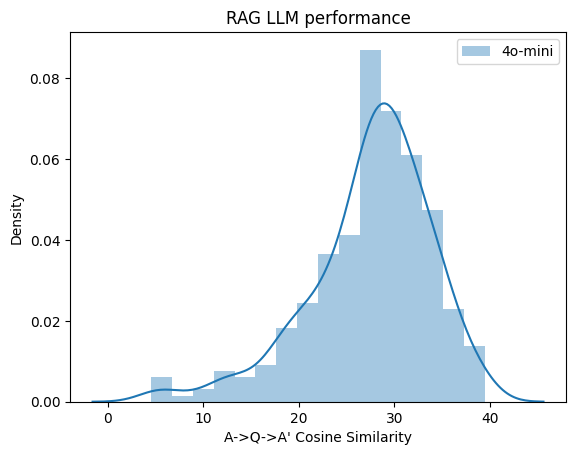

In [113]:

sns.distplot(gpt4omini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### Q3. Computing the cosine

What's the 75% cosine in the scores?

Answer: 0.83

In [114]:
import numpy as np

In [115]:
results_gpt4omini[0]

{'answer_llm': 'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [116]:
def norm(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v / norm
    return v_norm
    
def compute_similarity_norm(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    v_llm = norm(v_llm)
    v_orig = norm(v_orig)
    
    return v_llm.dot(v_orig)

In [117]:
similarity_norm = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity_norm(record)
    similarity_norm.append(sim)

  0%|          | 0/300 [00:00<?, ?it/s]

In [118]:
gpt4omini['cosine_norm'] = similarity_norm
gpt4omini['cosine_norm'].describe()

count    300.000000
mean       0.728393
std        0.157755
min        0.125357
25%        0.651273
50%        0.763761
75%        0.836235
max        0.958796
Name: cosine_norm, dtype: float64

/tmp/ipykernel_83712/3979333095.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gpt4omini['cosine_norm'], label='4o-mini')


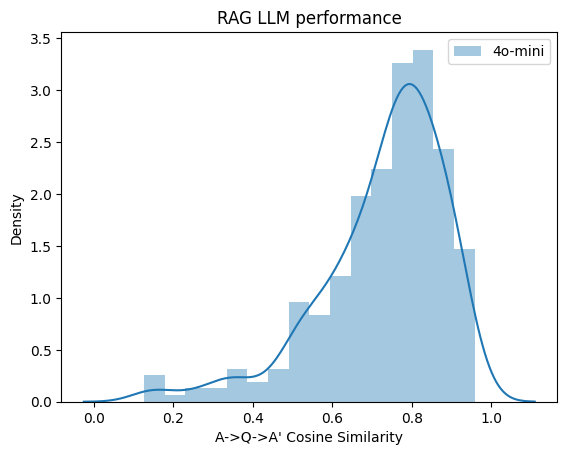

In [119]:

sns.distplot(gpt4omini['cosine_norm'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

### Q4. Rouge

What's the F score for rouge-1?

Answer: 0.45

In [120]:
# !pip install rouge

In [121]:
answer_llm = df.iloc[10].answer_llm
answer_llm

"Yes, all sessions are recorded, so if you miss one, you won't miss anything. You can catch up on the content later. Additionally, you can submit your questions in advance for office hours, and those sessions are also recorded."

In [122]:
# doc_id=5170565b
answer_orig = df.iloc[10].answer_orig
answer_orig

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [123]:
from rouge import Rouge
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(answer_llm, answer_orig)[0]

In [124]:
scores['rouge-1']['f']

0.45454544954545456

### Q5. Average rouge score

Let's compute the average F-score between rouge-1, rouge-2 and rouge-l for the same record from Q4

Answer: 0.35

In [125]:
f_scores = [scores['rouge-1']['f'], scores['rouge-2']['f'], scores['rouge-l']['f']]

np.average(f_scores)


0.35490034990035496

### Q6. Average rouge score for all the data points

What's the average F-score in rouge_2 across all the records?

Answer: 0.20

In [126]:
def compute_rouge_score(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    scores = rouge_scorer.get_scores(answer_llm, answer_orig)[0]
    rouge2_f = scores['rouge-2']['f']
    return rouge2_f

In [127]:
rouge2_f_scores = []

for record in tqdm(results_gpt4omini):
    rouge2_f = compute_rouge_score(record)
    rouge2_f_scores.append(rouge2_f)

  0%|          | 0/300 [00:00<?, ?it/s]

In [128]:
gpt4omini['rouge2_f'] = rouge2_f_scores
gpt4omini['rouge2_f'].describe()

count    300.000000
mean       0.206965
std        0.153550
min        0.000000
25%        0.097809
50%        0.178671
75%        0.286181
max        0.739130
Name: rouge2_f, dtype: float64